In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

# Download and preprocess data

In [2]:
# # MNIST Dataset transformation
# mnist_transform = transforms.Compose([
#     transforms.ToTensor(), # Converts to [0, 1] interval
#     transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
# ])

# # dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
# class FilteredMNIST(Dataset):
#     def __init__(self, mnist_dataset, labels):
#         # Extract only the data with the specified labels
#         self.data = [(img, label) for img, label in mnist_dataset if label in labels]
#         self.imgs = [img for img, label in self.data]
#         self.targets = [label for img, label in self.data]

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]


# # Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
# full_train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=mnist_transform, download=True)
# print("Original size of the dataset: ", len(full_train_dataset))
# filtered_labels = [0, 1]
# print("Filtered labels: ", filtered_labels)
# train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
# print("New size of the dataset: ", len(train_dataset))

# batch_size = 256
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)



# MNIST Dataset transformation
fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.FashionMNIST(root='fashionmnist_data', train=True, transform=fashionmnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,1,7]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 1, 7]
New size of the dataset:  18000


# Load saved model

In [3]:
# load the saved model
input_dim = train_dataset[0][0].shape[-1]
hidden_dims = [64, 32]
latent_dim = 2
hidden_activation = nn.Tanh()
encoder_output_mu_activation=nn.Identity()
encoder_output_logvar_activation=nn.Softplus()
decoder_output_mu_activation=nn.Sigmoid()
decoder_output_logvar_activation=nn.Softplus()

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network
k_rbf = 64
a = 2
zeta_rbf = 1e-6
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('torch_models/VAE_RBFNN_fashionmnist.pt'))

<All keys matched successfully>

# Encode and decode the whole dataset

In [4]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

### Construct the manifold

In [5]:
latent_means_np = latent_means.detach().numpy()

# The G_mode_parameters is used by the manifold class to compute the metric tensor
G_model_parameters = {'name': 'generator'}
w_counter = 0
b_counter = 0
for name, param in model_VAE_RBF.VAE.named_parameters():
    if ('dec' or 'mu_dec') in name:
        if 'weight' in name:
            key_name = 'W' + str(w_counter)
            G_model_parameters[key_name] = param.detach().numpy()
            w_counter += 1
        elif 'bias' in name:
            key_name = 'b' + str(b_counter)
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            b_counter += 1

G_model_parameters['activation_fun_hidden'] = str(hidden_activation).lower()  # Get the name of activFun e.g. Tanh() -> tanh
G_model_parameters['activation_fun_output'] = str(decoder_output_mu_activation).lower()
G_model_parameters['Wrbf'] = model_VAE_RBF.RBF.W_rbf.detach().numpy()  # The weights for the RBFs (D x K)
G_model_parameters['Crbf'] = model_VAE_RBF.RBF.centers_rbf.detach().numpy()  # The centers for the RBFs (K x d)
G_model_parameters['Grbf'] = model_VAE_RBF.RBF.lambdas_k.detach().numpy()  # * np.ones((K_rbf, 1))  # The precision for the RBFs (K x 1)
G_model_parameters['zeta'] = zeta_rbf  # A small value to prevent division by 0
G_model_parameters['beta'] = 1.0  # This scaling parameter of the metric is updated later

# Construct the manifold
manifold_latent = manifolds.MlpMeanInvRbfVar(G_model_parameters)
# Rescale the metric such that the maximum measure on the data to be 1
beta_rbf = 1 / (np.sqrt(np.linalg.det(manifold_latent.metric_tensor(latent_means_np.T)).max()))
G_model_parameters['beta'] = beta_rbf ** (2 / latent_dim)  # Rescale the pull-back metric
z1min, z2min = latent_means_np.min(0) - 0.5
z1max, z2max = latent_means_np.max(0) + 0.

### Compute curve on the manifold

[Initialize Graph] [Processed point: 0/64]


/home/clement/Documents/MVA/geometric_data_analysis/latent_space_oddity/core/geodesics.py:133: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  curve_length_eval = integrate.quad(lambda t: local_length(manifold, curve, t), a, b, epsabs=tol, limit=limit)  # , number of subintervals


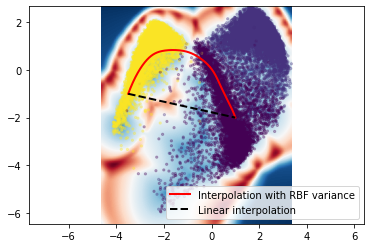

In [6]:
plt.figure()
utils.plot_measure(manifold_latent, np.linspace(z1min, z1max, 100), np.linspace(z2min, z2max, 100))
utils.my_plot(latent_means_np, c=labels, s=5, alpha=0.3)

# Compute some random curve using a heuristic graph solver
GRAPH_DATA = KMeans(n_clusters=64, n_init=30, max_iter=1000).fit(latent_means_np).cluster_centers_
solver_graph = geodesics.SolverGraph(manifold_latent, data=GRAPH_DATA, kNN_num=5, tol=1e-2)

#ind_0, ind_1 = np.random.choice(len(train_dataset), 2, replace=False)
# ind_0 = 0
# ind_1 = 3040
# c0 = latent_means_np[ind_0, :].reshape(-1, 1)
# c1 = latent_means_np[ind_1, :].reshape(-1, 1)
c0 = np.array([[-3.5], [-1.]])
c1 = np.array([[1.], [-2.]])

curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
    = geodesics.compute_geodesic(solver_graph, manifold_latent, c0, c1)
geodesics.plot_curve(curve_graph, c='r', linewidth=2, label = 'Interpolation with RBF variance')
plt.plot([c0[0, 0], c1[0, 0]], [c0[1, 0], c1[1, 0]], 'k--', linewidth=2, label = 'Linear interpolation')
plt.legend()

curve_length_graph:  (2, 12)
curve_length_graph:  [[-3.5        -3.1592346  -2.77301095 -2.35876005 -1.835816   -1.2184353
  -0.68580874 -0.16176245  0.22565931  0.52226915  0.80846663  1.        ]
 [-1.         -0.22900177  0.35946257  0.70285653  0.82991379  0.80789158
   0.6252286   0.23046038 -0.33783814 -0.96426339 -1.54060758 -2.        ]]


/tmp/ipykernel_1198174/2418126060.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(curve_eval[0, :], curve_eval[1, :],'k--', c='r', linewidth=2)


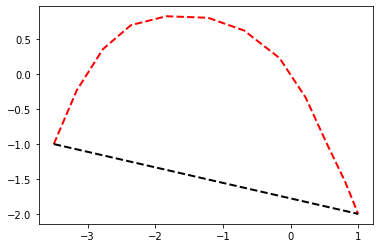

In [7]:
# display the curve
curve_eval = curve_graph(np.linspace(0, 1, 12))[0]
print('curve_length_graph: ', curve_eval.shape)
plt.plot(curve_eval[0, :], curve_eval[1, :],'k--', c='r', linewidth=2)
plt.plot([c0[0, 0], c1[0, 0]], [c0[1, 0], c1[1, 0]], 'k--', linewidth=2)
print('curve_length_graph: ', curve_eval)

In [8]:
# generate data on the line between c0 et c1
T = np.linspace(0, 1, 12)
interpolation_linear = [ (1-t)*c0 + t*c1 for t in T]
interpolation_linear = np.array(interpolation_linear)
interpolation_linear = interpolation_linear.squeeze()
print('interpolation_linear: ', interpolation_linear)

interpolation_linear:  [[-3.5        -1.        ]
 [-3.09090909 -1.09090909]
 [-2.68181818 -1.18181818]
 [-2.27272727 -1.27272727]
 [-1.86363636 -1.36363636]
 [-1.45454545 -1.45454545]
 [-1.04545455 -1.54545455]
 [-0.63636364 -1.63636364]
 [-0.22727273 -1.72727273]
 [ 0.18181818 -1.81818182]
 [ 0.59090909 -1.90909091]
 [ 1.         -2.        ]]


## Display images generated from the interpolated points

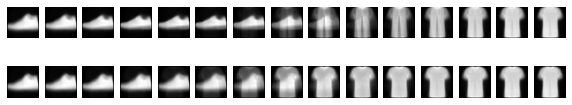

In [13]:
def generate_data_from_latent(model_VAE, latent_points):

    mu, _ = model_VAE.decode(latent_points)

    mu = mu.cpu().numpy()
    #threshold = 0.5
    #binary_image = (mu > threshold).astype(np.float32)
    return mu
    
with torch.no_grad():
    # Exemple d'utilisation
    num_samples_to_generate = 15
    T = np.linspace(0, 1, num_samples_to_generate)

    # générer des données sur l'interpolation avec RBF
    curve_eval = curve_graph(T)[0]
    interpolation_var = curve_eval.T
    z = torch.from_numpy(interpolation_var.astype(np.float32))
    generated_data_var = generate_data_from_latent(model_VAE_RBF.VAE, z)
    
    # générer des données sur l'interpolation linéaire
    interpolation_linear = [ (1-t)*c0 + t*c1 for t in T]
    interpolation_linear = np.array(interpolation_linear)
    interpolation_linear = interpolation_linear.squeeze()
    z = torch.from_numpy(interpolation_linear.astype(np.float32))
    generated_data_linear = generate_data_from_latent(model_VAE_RBF.VAE, z)

    # Visualiser les images
    generated_data_var = generated_data_var.reshape(num_samples_to_generate, 28, 28)
    generated_data_linear = generated_data_linear.reshape(num_samples_to_generate, 28, 28)
    fig, axes = plt.subplots(2, num_samples_to_generate, figsize=(10, 2))
    for i in range(num_samples_to_generate):
        axes[0, i].imshow(generated_data_var[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(generated_data_linear[i], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('RBF')
    axes[1, 0].set_ylabel('Linear')
    plt.show()